In [1]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import glob
import numpy as np
import pandas as pd
import functools
import os
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from itertools import product

%matplotlib inline
ia.seed(1)

In [2]:
def bb_midpoint_to_corner(bb):
    label = bb[0]
    x1 = bb[1] - bb[3]/2
    x2 = bb[1] + bb[3]/2
    y1 = bb[2] - bb[4]/2
    y2 = bb[2] + bb[4]/2
    corner_list = [label, x1, x2, y1, y2]
    return np.array(corner_list)

def bb_corner_to_midpoint(bb):
    label = bb[0]
    x = bb[1] + (bb[2] - bb[1])/2
    y = bb[3] + (bb[4] - bb[3])/2
    w = bb[2] - bb[1]
    h = bb[4] - bb[3]
    midpoint_list = [label, x, y, w, h]
    return np.array(midpoint_list)

def bbs_to_bb(bbs_list, width, height):
    try:
        corner_list = []
        for bbs in bbs_list:
            label = bbs.label
            x1 = bbs.x1/width
            x2 = bbs.x2/width
            y1 = bbs.y1/height
            y2 = bbs.y2/height
            corner_list.append([label, x1, x2, y1, y2])

        midpoint_list = np.apply_along_axis(bb_corner_to_midpoint, axis=1, arr=corner_list)
        return np.array(midpoint_list)
    except Exception as e:
        #print(e)
        return np.array([])

def save_bb_txt(bbs_df, name):
    bbs_df.to_csv(name, index = False, header = False, sep = " ", float_format='%.6f')

def open_yolo(image_name, label_path):
    try: 
        image = imageio.imread(image_name)
        shape = image.shape
        width = shape[1]
        height = shape[0]
        label = label_path + image_name.split("/")[-1].split(".")[0] + ".txt"
        boxes = np.genfromtxt(label, delimiter=' ')
        # reshaping the np array is necessary in case a file with a single box is read
        boxes = boxes.reshape(boxes.size//5, 5)
        #print(boxes.shape)
        boxes = np.apply_along_axis(bb_midpoint_to_corner, axis=1, arr=boxes)
        bbs = BoundingBoxesOnImage([BoundingBox(x1=list[1]*width, x2=list[2]*width, y1=list[3]*height, y2=list[4]*height, label = int(list[0])) for list in boxes], shape=image.shape)
        return image, bbs
    except Exception as e:
        #print(e)
        return None, None

def calculate_position(index, factor):
    # since the crops are center aligned, the edges (0.0 and 1.0) can't use the same expression
    return 1 if index == 0 else 0 if index == (factor - 1) else (1 - index/factor) - 1/(factor*2)

In [3]:
image_path = "../yolo-station/images_bgr/"
label_path = "../yolo-station/labels_sub/"

image_list = os.path.join(os.path.join(image_path, "*.*"))
label_list = []

image_list = glob.glob(image_list)
for name in image_list:
    label_list.append(label_path + name.split("/")[-1].split(".")[0] + ".txt")


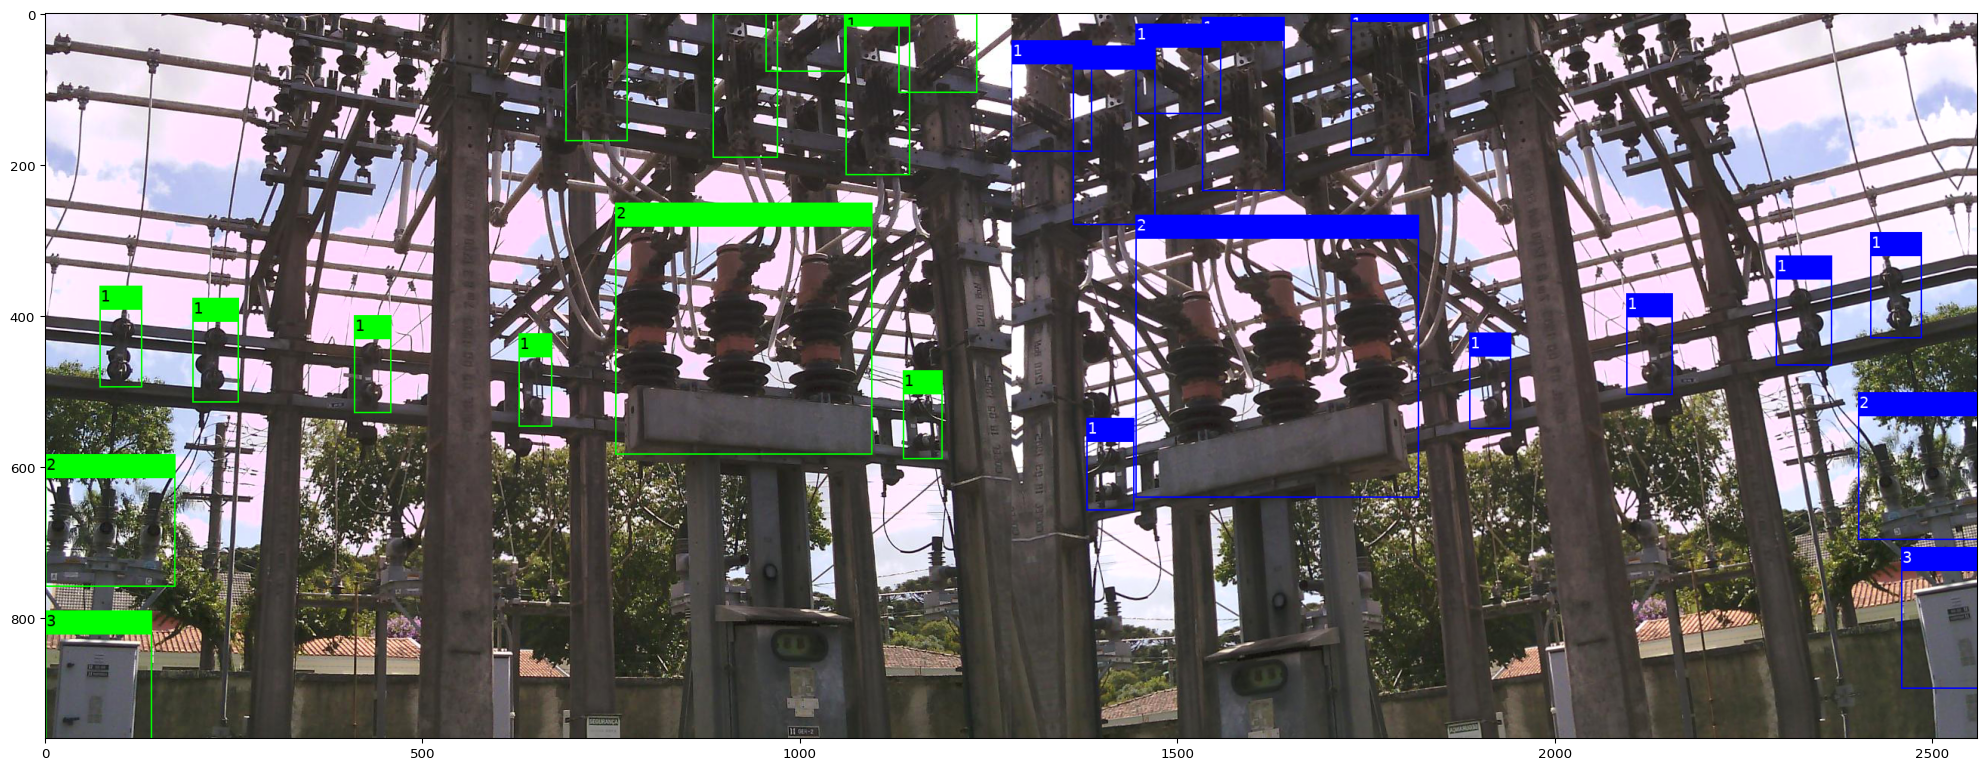

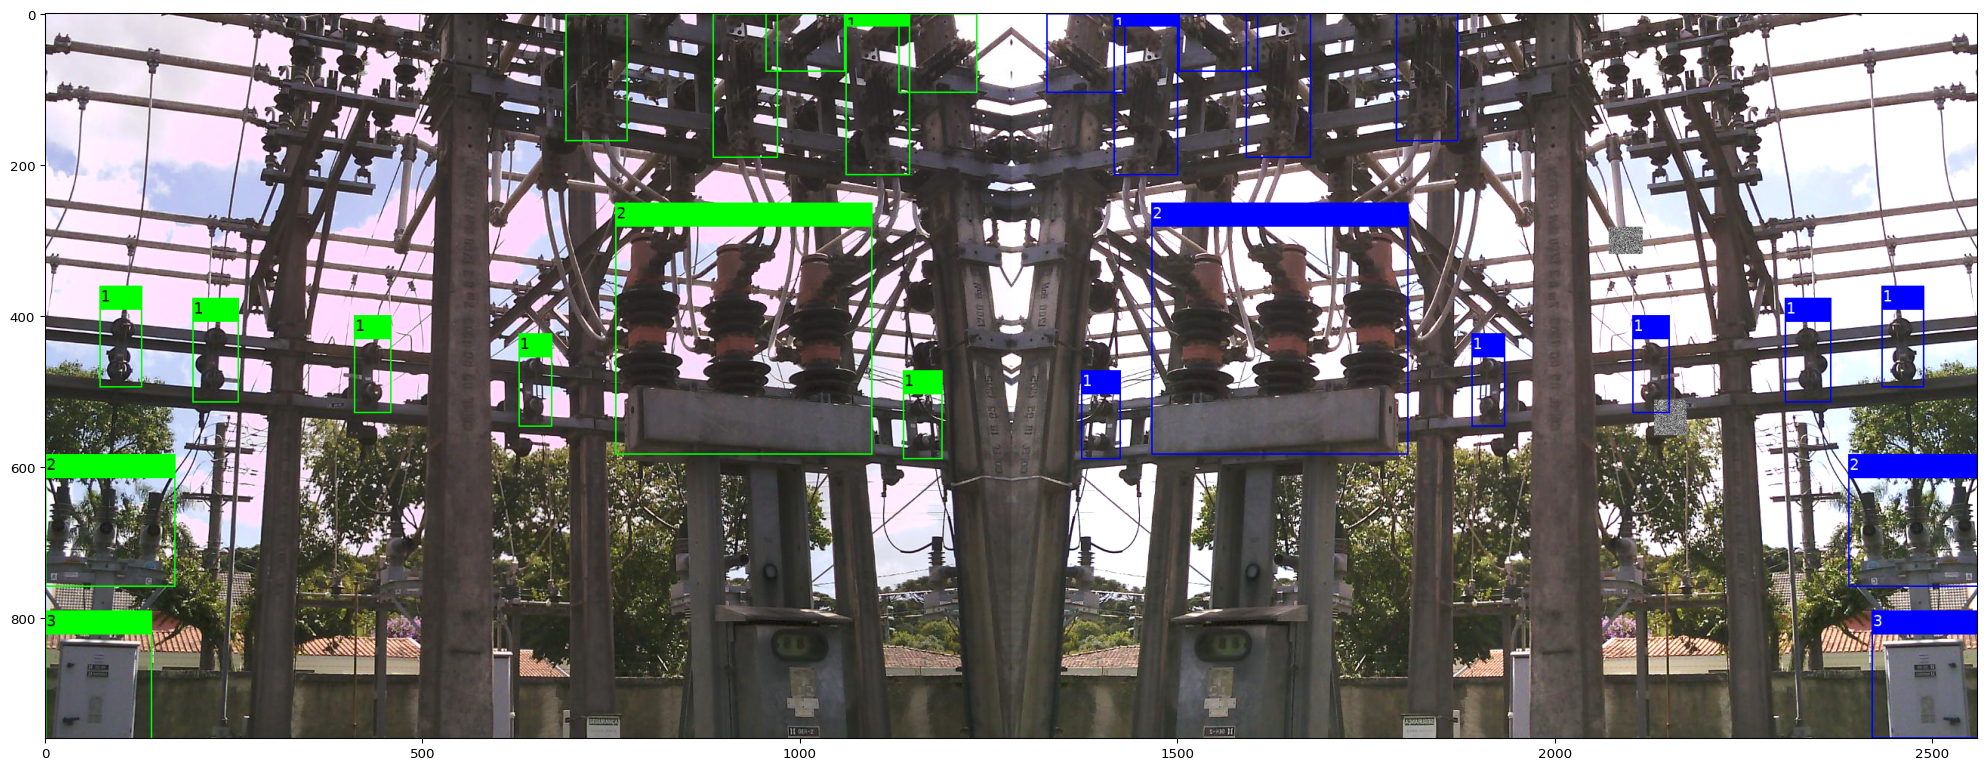

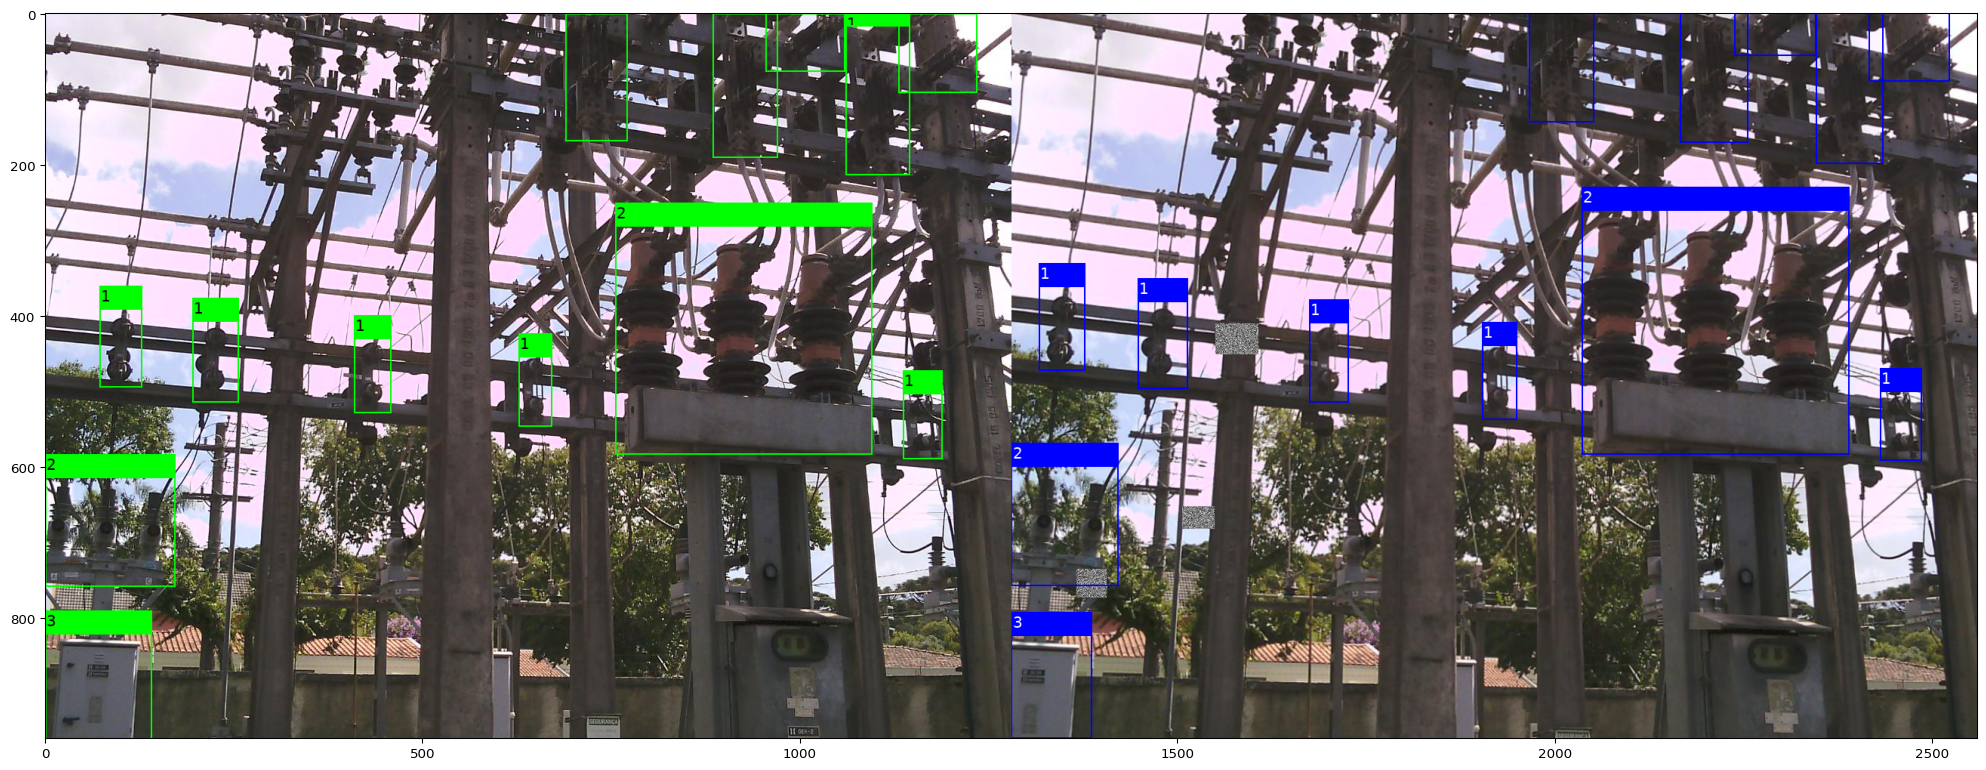

Number of images: 1
Number of augmented images: 3


In [14]:
augmented_count = 0
image_count = 0
aug_num = 3 # number of augmented images per image

for im in image_list[23:24]:
    count = 0
    image_name = im
    #print(image_name)
    image, bbs = open_yolo(image_name, label_path)
    # if the image or the label file doesn't exist, skip this iteration
    if((image is None) or (bbs is None)):
        continue
    image_count += 1
    shape = image.shape
    width = shape[1]
    height = shape[0]
    
    for i in range(0, aug_num):
        # available modes: constant, edge, linear_ramp, maximum, mean, median, minimum, reflect, symmetric and wrap
        aug = iaa.Sequential([iaa.SomeOf((2, 3), [iaa.OneOf([iaa.Affine(rotate=(-10, 10), mode="reflect"),
                                             iaa.PerspectiveTransform(scale=(0, 0.1))]),
                                  iaa.Multiply((0.7, 1.3)),
                                  iaa.Cutout(nb_iterations=(1, 4), size=(0.03, 0.06), squared=False, fill_mode="gaussian")]
                                  ),
                                iaa.Fliplr(0.5)])
        #seq =  iaa.Sequential([iaa.Sometimes(0.1, iaa.Affine(rotate=(-10, 10))),
        #                       iaa.Sometimes(0.3, iaa.PerspectiveTransform(scale=(0, 0.15))),
        #                        iaa.Sometimes(0.2, iaa.Multiply((0.7, 1.3)))
        #                     ]) 
        image_aug, bbs_aug = aug(image=image, bounding_boxes=bbs)
        bbs_aug = bbs_aug.remove_out_of_image().clip_out_of_image()

        before_image = bbs.draw_on_image(image, size=2)
        after_image = bbs_aug.draw_on_image(image_aug, size=2, color=[0, 0, 255])
        ia.ia.show_grid([before_image, after_image], rows=1, cols=2)

        bb = bbs_to_bb(bbs_aug, width, height)
        # we only want to save the image if it has boxes in it
        if (len(bb) > 0):
            # saving the image
            aug_name = image_name.split("/")[-1].split(".")[0]
            imageio.imwrite("./aug_images/" + aug_name + "_aug_" + str(count) + ".jpg", image_aug)
            # saving the YOLO bb file
            df_bb = pd.DataFrame(bb, columns = ["label", "x", "y", "w", "h"])
            df_bb["label"] = df_bb["label"].astype(int)
            save_bb_txt(df_bb, "./aug_labels/" + aug_name + "_aug_" + str(count) + ".txt")
            augmented_count += 1
        count += 1
print("Number of images: {}".format(image_count))
print("Number of augmented images: {}".format(augmented_count))